# **Graph Classification with 🤗 Transformers**

This notebook shows how to fine-tune the **Graphormer** model for Graph Classification on a dataset available on the hub. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory(OOM) errors. 

In this notebook, we'll fine-tune from the https://huggingface.co/clefourrier/pcqm4mv2-graphormer-base checkpoint.

## Fine-tuning Graphormer on an graph classification task

In this notebook, we will see how to fine-tune the Graphormer model on [🤗 Transformers](https://github.com/huggingface/transformers) on a Graph Classification dataset.

Given a graph, the goal is to predict its class.

In [5]:
import os
CUDA_VISIBLE_DEVICES = "0,1,2"

### Loading the dataset

Loading a graph dataset from the Hub is very easy. Let's load the `VincentPai/encoded-MITRE` dataset, stored in the `VincentPai` repository. 
*To find other graph datasets, look for the "Graph Machine Learning" tag on the hub:  [here](https://huggingface.co/datasets?task_categories=task_categories:graph-ml&sort=downloads). You'll find social graphs, molecular datasets, some artificial ones, etc!*

In [6]:
from datasets import load_dataset 

# dataset = load_dataset("VincentPai/for-graphormer-new2")
dataset = load_dataset("VincentPai/encoded-MITRE")

# rename the label to y to fit the format of the input of the Graphormer
# dataset['train'] = dataset['train'].rename_column('label', 'y')

dataset = dataset.shuffle(seed = 87)

Found cached dataset json (/workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-866ffe29a73f78c8.arrow
Loading cached shuffled indices for dataset at /workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-ca9a9a2bbcdb7ed1.arrow
Loading cached shuffled indices for dataset at /workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-0233e4faf4c367f7.arrow


Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [7]:
from datasets import load_metric
metric = load_metric("accuracy")

/tmp/ipykernel_2647/3366162530.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, "train", "validation" and "test" splits).

In [8]:
# dataset
print(dataset, dataset["train"][0], sep = '\n')
# print(dataset["test"][0])

DatasetDict({
    train: Dataset({
        features: ['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index'],
        num_rows: 2959563
    })
    validation: Dataset({
        features: ['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index'],
        num_rows: 986521
    })
    test: Dataset({
        features: ['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index'],
        num_rows: 986521
    })
})
{'y': [0], 'num_nodes': 3, 'node_feat': [[368205], [6], [585037]], 'edge_attr': [[0], [0]], 'edge_index': [[0, 1], [1, 2]]}


We can inspect the graph using networkx and pyplot.

[[0, 1], [1, 2]]
{'y': [0], 'num_nodes': 3, 'node_feat': [[368205], [6], [585037]], 'edge_attr': [[0], [0]], 'edge_index': [[0, 1], [1, 2]]}


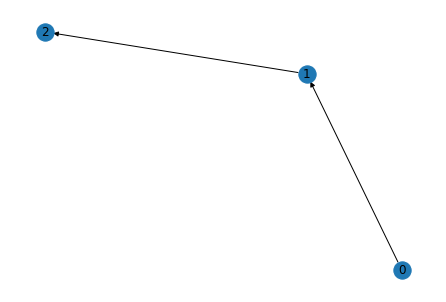

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
# We want to plot the first train graph
graph = dataset["train"][0] # would be a json here
edges = graph["edge_index"]

print(graph["edge_index"])
print(graph)

num_edges = len(edges[0])
num_nodes = graph["num_nodes"]

G = nx.Graph()
G = nx.DiGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from([(edges[0][i], edges[1][i]) for i in range(num_edges)])

# Plot
nx.draw(G, with_labels=True)


# print(graph["node_feat"], type(graph["node_feat"]))
# graph["node_feat"].append(0)
# print(graph["node_feat"])

### Preprocessing the data

Graph transformer frameworks usually apply specific preprocessing to their datasets to generate added features and properties which help the underlying learning task (classification in our case).

Here, we use Graphormer's default preprocessing, which generates in/out degree information, the shortest path between node matrices, and other properties of interest for the model. 

In [10]:
from transformers.models.graphormer.collating_graphormer import preprocess_item, GraphormerDataCollator
dataset_processed = dataset.map(preprocess_item, batched=False)

Loading cached processed dataset at /workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-647ec9f1adc9e746.arrow
Loading cached processed dataset at /workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-dfd6f8ef02371a10.arrow
Loading cached processed dataset at /workdir/home/euni/.cache/huggingface/datasets/VincentPai___json/VincentPai--encoded-MITRE-5bdfa67a52216983/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-96b9d49c74e7a073.arrow


In [11]:
dataset_processed

DatasetDict({
    train: Dataset({
        features: ['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'],
        num_rows: 2959563
    })
    validation: Dataset({
        features: ['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'],
        num_rows: 986521
    })
    test: Dataset({
        features: ['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'],
        num_rows: 986521
    })
})

In [12]:
# split up training into training + validation

train_ds = dataset_processed['train']
val_ds = dataset_processed['validation']

### Debugging Part for the data format

In [13]:
import numpy as np

print(train_ds[0].keys())

# print(train_ds[0]['attn_bias'].shape)

# attn_bias is 4x4
print(train_ds[0]['num_nodes'])
print(train_ds[0]['attn_bias'])
print(train_ds[0]['node_feat'])
print(train_ds[0]['input_nodes'], len(train_ds[0]['input_nodes']), sep='\n')

my_array = np.array(train_ds[0]['input_nodes'])
print('input_nodes shape:', my_array.shape)

my_array = np.array(train_ds[0]['attn_bias'])
print('attn_bias shape:', my_array.shape, end='\n\n')

''' 
attn_bias = np.zeros([num_nodes + 1, num_nodes + 1], dtype=np.single)  # with graph token -> 4x4 in our case
item["attn_bias"] = attn_bias # in our case, it will be 4x4 tensor with element 0

batch["attn_bias"] = torch.ze ros(batch_size, max_node_num + 1, max_node_num + 1, dtype=torch.float)
max_node_num = max(len(i["input_nodes"]) for i in features)

error : batch["attn_bias"][ix, : f["attn_bias"].shape[0], : f["attn_bias"].shape[1]] = f["attn_bias"] 
'''


dict_keys(['y', 'num_nodes', 'node_feat', 'edge_attr', 'edge_index', 'input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels'])
3
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
[[368205], [6], [585037]]
[[368208], [9], [585040]]
3
input_nodes shape: (3, 1)
attn_bias shape: (4, 4)



' \nattn_bias = np.zeros([num_nodes + 1, num_nodes + 1], dtype=np.single)  # with graph token -> 4x4 in our case\nitem["attn_bias"] = attn_bias # in our case, it will be 4x4 tensor with element 0\n\nbatch["attn_bias"] = torch.ze ros(batch_size, max_node_num + 1, max_node_num + 1, dtype=torch.float)\nmax_node_num = max(len(i["input_nodes"]) for i in features)\n\nerror : batch["attn_bias"][ix, : f["attn_bias"].shape[0], : f["attn_bias"].shape[1]] = f["attn_bias"] \n'

In [14]:
def convert_to_single_emb(x, offset: int = 512):
    feature_num = x.shape[1] if len(x.shape) > 1 else 1
    feature_offset = 1 + np.arange(0, feature_num * offset, offset, dtype=np.int64)
    x = x + feature_offset
    return x


node_feat = [[445528, 24, 740662]]
node_feature = np.asarray(node_feat, dtype=np.int64)
input_nodes = convert_to_single_emb(node_feature) + 1
print(input_nodes.shape)

node_feat = [[445528], [24], [740662]]
node_feature = np.asarray(node_feat, dtype=np.int64)
input_nodes = convert_to_single_emb(node_feature) + 1
print(input_nodes.shape)

node_feat_2 = [[445528, 24, 740662]] 
print(node_feat_2[0][1])

# 將node_feat轉換為3x1的二維陣列
node_feat_2d_array = [[item[0]] for item in node_feat_2]

print(node_feat_2d_array)

(1, 3)
(3, 1)
24
[[445528]]


### Training the model


Calling the `from_pretrained` method on our model downloads and caches the weights for us. As the number of classes (for prediction) is dataset dependent, we pass the new `num_classes` as well as `ignore_mismatched_sizes` alongside the `model_checkpoint`. This makes sure a custom classification head is created, specific to our task, hence likely different from the original decoder head. 

(When using a pretrained model, you must make sure the embeddings of your data have the same shape as the ones used to pretrain your model.)

In [16]:
from transformers import GraphormerForGraphClassification

model_checkpoint = "clefourrier/graphormer-base-pcqm4mv2" # pre-trained model from which to fine-tune

model = GraphormerForGraphClassification.from_pretrained(
    model_checkpoint, 

    # We have 167 attack patterns and 1 benign
    num_classes=168, 

    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of GraphormerForGraphClassification were not initialized from the model checkpoint at clefourrier/graphormer-base-pcqm4mv2 and are newly initialized because the shapes did not match:
- classifier.classifier.weight: found shape torch.Size([1, 768]) in the checkpoint and torch.Size([168, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

For graph datasets, it is particularly important to play around with batch sizes and gradient accumulation steps to train on enough samples while avoiding out-of-memory errors. 

In [19]:
from tqdm import tqdm
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    "graph-classification",
    logging_dir="graph-classification",
    
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,

    auto_find_batch_size=False, # batch size can be changed automatically to prevent OOMs
    gradient_accumulation_steps=10,
    dataloader_num_workers=4, 

    num_train_epochs=5,

    evaluation_strategy="epoch",
    logging_strategy="epoch",
    push_to_hub=False,

    disable_tqdm=False,  # show the tqdm bar
)

To get the error message

In [20]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In the `Trainer` for graph classification, it is important to pass the specific data collator for the given graph dataset, which will convert individual graphs to batches for training. 

In [22]:
from transformers import TrainerCallback

class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        print(f"Epoch: {state.epoch}, Step: {state.global_step}, Loss: {state.log_history[-1]['loss']}")


In [23]:
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction

def compute_accuracy(p: EvalPrediction):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,

    # data collator is important in our task
    data_collator=GraphormerDataCollator(),
    callbacks=[PrintLossCallback()],
    compute_metrics=compute_accuracy,
)

We can now train our model!

In [25]:
train_results = trainer.train()

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/workdir/home/euni/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


You can now upload the result of the training to the Hub with the following:
- Need to login first(add some code in the front of the script)

In [ ]:
trainer.push_to_hub()